# Comparación de modelos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
results_save_path = "../experimentos_split/results"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300


Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:  row_132
Processing: 

## Comparación

In [4]:
from utils import pygt_loader
import os
import torch
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions, plot_multiple_models

from utils.trainer import TrainerModel, TrainerAGCRN, TrainerDryGrEncoder, TrainerLSTMModel, TrainerMPNNLSTM
from utils import trainer
dtype = torch.float
import ast
device = torch.device("mps")
import utils.models

In [5]:
problem = "gen_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/gen_trip


In [6]:
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)

n_div_gt = loader.div


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [7]:
def process_model(name, path_problem_results, dataset, dataloader_params_nobatch):

    dataloader_params_nobatch['use_batch'] = False
    dataloader_params = dataloader_params_nobatch.copy()
    dataloader_params['use_batch'] = True


    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

    df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
    if name not in df['Modelo'].values:
        raise ValueError("Modelo no tiene resultados en el directorio de resultados")
    params_prelim = df[df['Modelo']==name]['Params'].values[0]
    try:
        params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
    except ValueError:
        params = {}


    if name =='DyGrEncoder':
        model= utils.models.DyGrEncoderModel("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=params['conv'], num_lstm=params['lstm'], aggr=params['aggr'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =='AGCRN':
        model = utils.models.AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=params['hidden'],k=params['k'], n_target=n_target, name="AGCRN")
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params, verbose=False)

    #No hemos hecho ajuste de parámetros
    elif name =='LSTM':
        model = utils.models.LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params, batch=True, verbose=False)
        
    elif name =='LSTM_NOBATCH':
        model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, batch=False, verbose=False)

    elif name == "MPNN_LSTM":
        model = utils.models.MPNNLSTMModel("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['hidden_size'], window=1, dropout=params['dropout'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMPNNLSTM(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    else:
        raise ValueError("Modelo no encontrado")
    return trainer


In [22]:
models_analysis = [ "DyGrEncoder", "LSTM"]
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}
predictions = {}
real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
for model_name in models_analysis:
    print("\n\nModelo: ", model_name)
    trainer = process_model(model_name, path_problem_results, dataset, dataloader_params)
    _,_,_,preds, reals = trainer.test()
    predictions[model_name] = preds
    real[model_name] = reals




Modelo:  DyGrEncoder

==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006246, test r2score -1.204836


Modelo:  LSTM

==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.007638, test r2score 0.204209


In [25]:
from importlib import reload

utils_graph =reload(utils.utils_graph)
from utils.utils_graph import plot_predictions, plot_multiple_models

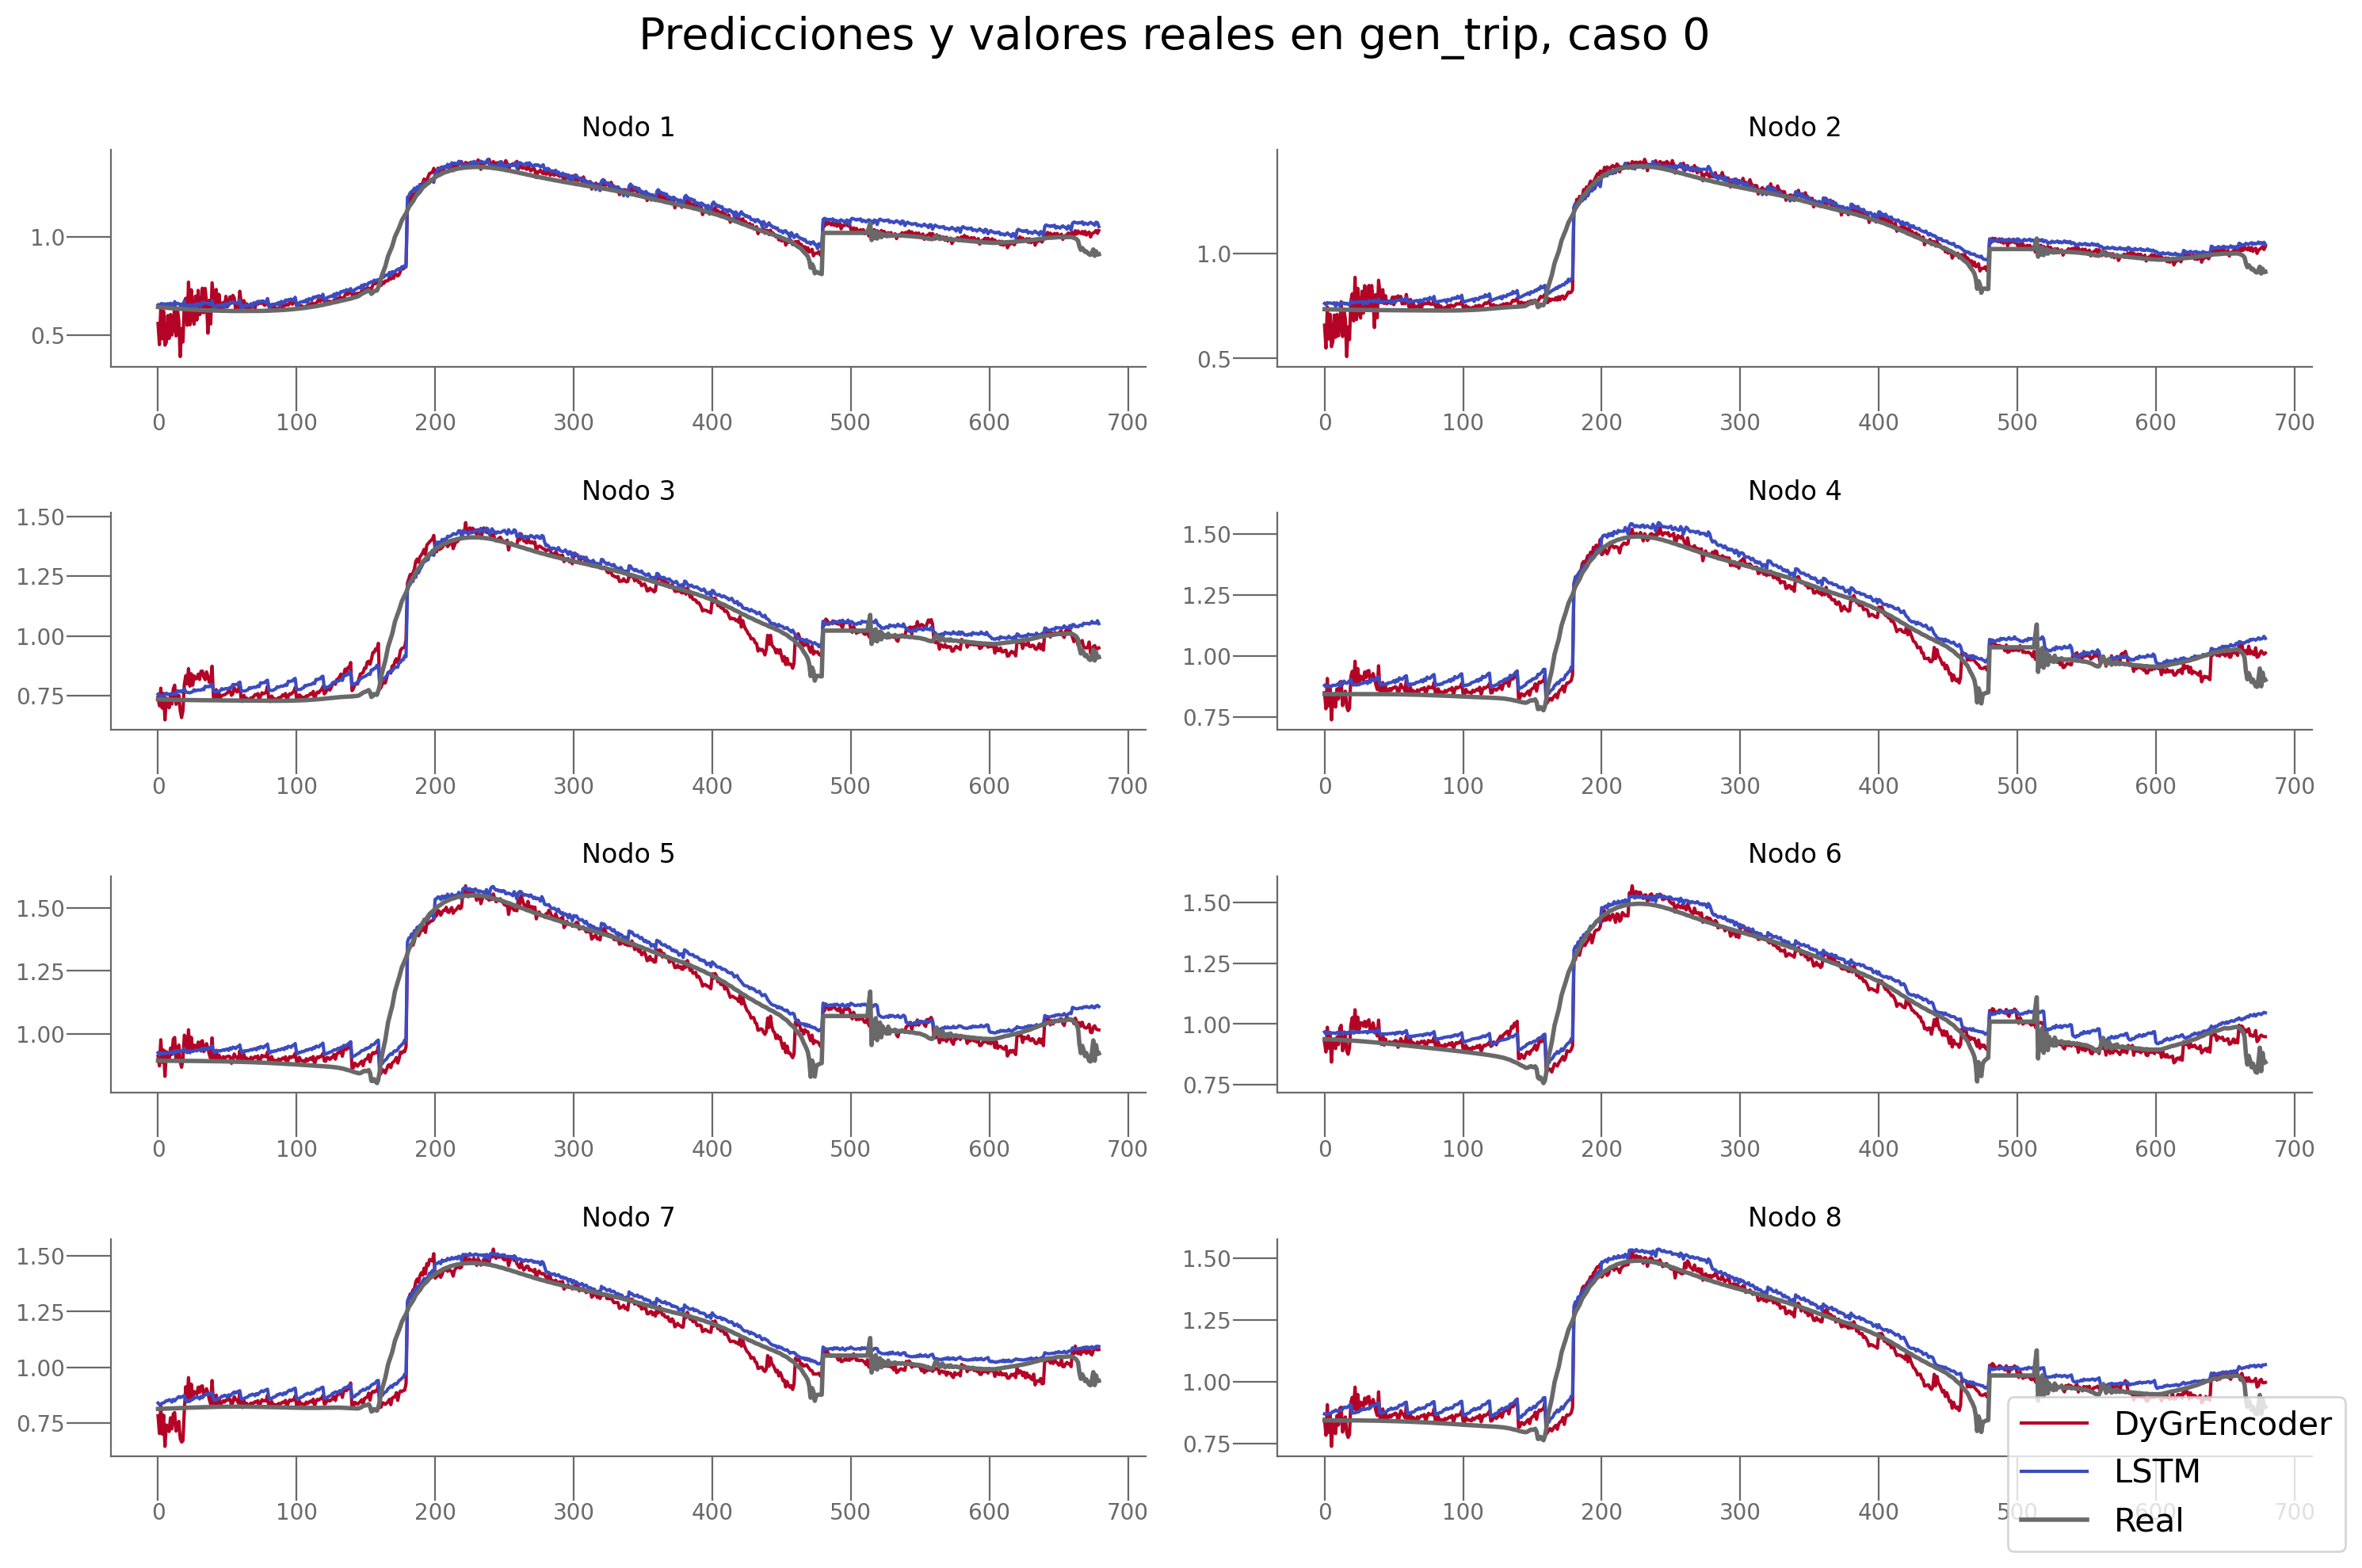

In [26]:
predictions_list= [value for value in predictions.values()]
real_list = [value for value in real.values()]

plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=0, n_div=n_div_gt, problem=problem, names_models = models_analysis)
